# CML wet/dry detection on 1 CML using CNN architecture of Polz J. [2]

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import cnn
import xarray as xr               # work with arrays, also possible with pandas
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# import einops
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output


#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step

In [4]:
# reference RADOLAN data from pycomlink with 5 min time step
# Path averaged reference RADOLAN data aligned with all 500 CML IDs
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')

## CML data preprocessing
1. choosing cml for training  
2. replacing fault values
3. cnalculating TRSL
4. resampling data  
5. creating dataset of training and reference data + data visualisation
6. Standardising

All from pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### Choose one CML, repair fault data and calculate TRSL

In [50]:
# Choose one cml
k = 14; # index of chosen cml 0-499
my_cml = cml_set.isel(cml_id = k) # https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
my_ref = ref_set.isel(cml_id = k)

# Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
my_cml['tsl'] = my_cml.tsl.where(my_cml.tsl != 255.0)
my_cml['rsl'] = my_cml.rsl.where(my_cml.rsl != -99.9)

# Calculate TRSL
my_cml['trsl'] = my_cml.tsl - my_cml.rsl

# Iterpolate missing values: From pycomlink
my_cml['trsl'] = my_cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

# show CML dataset
# my_cml

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

In [78]:
my_data_set = my_cml.assign(my_ref)

## Building dataset

#### Agregate 1h measurements into sample
To build samples for CNN. rain event will be predicted for whole sample
60 times 1 min time step = 1 hour time window   
source: chatGPT

__TODO: Possible simplification using .reshape or .view and rewriting trsl, ref_wet_dry__

In [8]:
# extract metadata:
cml_id = my_data_set.cml_id.values
length = my_data_set.length.values
frequency = my_data_set.frequency.values
polarization = my_data_set.polarization.values

In [9]:
sample_size = 60 # =1 h
# get number of samples 
n_samples = len(my_data_set.time) // sample_size 
n_samples

264

In [51]:
# Reshape dataset to a new shape with the sample_id dimension
# last few points cant make a sample of 120. Will be cut off. 
trsl_reshaped = my_data_set['trsl'].values[0:(n_samples*sample_size)] 
# reshape
trsl_reshaped = trsl_reshaped.reshape(n_samples, 2, sample_size)   #2 stands for 2 channels
#trsl_reshaped # array of 264 samples and 2 channels containing 60 trsl measurements

In [52]:
# last few points cant make a sample. Has to be cut off. 
rain_reshaped = my_data_set['rainfall_amount'].values[0:(n_samples*sample_size)]  # //5 because ref_data is with 5x denser timestep
# reshape
rain_reshaped = rain_reshaped.reshape(n_samples, sample_size)
# rain_reshaped # array of n samples containing 1 hour of rain rate measurements


In [62]:
# reshape and add vector of time into dataset to remember the time stamp
time_reshaped = my_data_set['time'].values[0:(n_samples*sample_size)]  # //5 because ref_data is with 5x denser timestep
# reshape
time_reshaped = time_reshaped.reshape(n_samples, sample_size)

In [63]:
# Create a new xarray Dataset with sample_num as a dimension
# replace time and date with timestep in the time sample
ds = xr.Dataset({
    'trsl': (('sample_num', 'channel_id', 'timestep'), trsl_reshaped),
    'rain': (('sample_num', 'timestep'), rain_reshaped),
    'time': (('sample_num', 'timestep'), time_reshaped)
}, coords={#'sample_num': np.arange(n_samples),
           #'channel_id': np.arange(2),
           #'timestep': np.arange(sample_size),
           #'cml_id': cml_id,
           #'length': length,                                  #single value is never a dimension
           #'frequency': (('channel_id'), frequency),          # this way coordinate will not become a dimension
           #'polarization': (('channel_id'), polarization)
            })
            
# make sure TRSL coordinates are in correct order
ds['trsl'] = ds.trsl.transpose('sample_num', 'channel_id', 'timestep')

In [102]:
# create one boolean wet/dry flag for whole 1hour sample [2]
last_hour = range(-1,-sample_size,-1)    # 264 samples 

# create one boolean wet/dry flag for whole sample [2]
ds['wet_dry'] = ds.rain.isel(timestep=last_hour).sum(dim='timestep')>0.

#### Plot dataset of the one chosen cml 

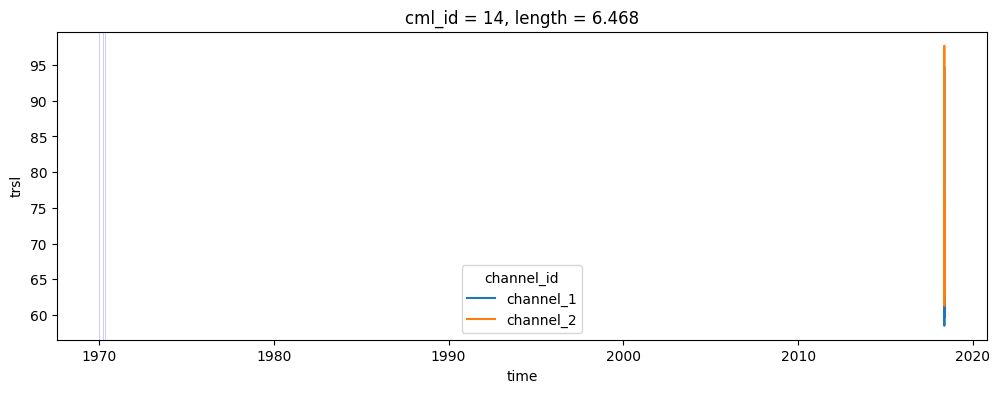

In [105]:
# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
ds['wet_dry'][0] = False 
ds['wet_dry'][-1] = False

# setup figure
fig, ax = plt.subplots(figsize=(12,4), sharex=True)
my_data_set.trsl.plot.line(x='time', ax=ax, label = 'TL');

wet_start = np.roll(ds.wet_dry, -1) & ~ds.wet_dry
wet_end = np.roll(ds.wet_dry, 1) & ~ds.wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='b', alpha=0.2, linewidth=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    

In [104]:
# histogram from: https://isibrno.cz/deep/
plt.figure()
plt.hist(my_data_set.trsl)
plt.title(f'Histogram of TRSL')
plt.xlabel('TRSL [dB]')
plt.ylabel('Frequency')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002B1011C8B80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002B11FA75620> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

#### <span style="color:red">TODO: </span>Standardising
Subtracting the median of all available data from the preceding 72h from each time step [2] 
maybe divide all trsl points with the higest trsl value


#### <span style="color:red">TODO: </span>We need to make Wet/Dry periods 50:50 for the training

In [ ]:
# from [2]
'''
def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))
'''

In [ ]:
# ds = balance_classes(ds, ~ds.wet_radar.values)

In [ ]:
# ds = ds.isel(sample_number=np.arange(100))

#### Training/Testing data splitting
https://github.com/jpolz/cml_wd_pytorch/blob/main/wd_pytorch/train_cnn.ipynb [2]

In [ ]:
batchsize = 10
k_train = 0.8     # fraction of training data

train_size = int(len(ds.sample_num)*k_train/batchsize)* batchsize
train_size

#### Convert to Tensor DataSets

Shuffling data, splitting and turning to arrays

In [ ]:
# shuffling samples
#trsl, ref = shuffle(ds.trsl.values, ds.wet_radar.values)

# without shuffling
trsl = ds.trsl.values
ref = ds.wet_dry.values

train_data = trsl[:train_size]
test_data = trsl[train_size:]
train_ref = ref[:train_size]
test_ref = ref[train_size:]
# to floor batch size use: data = data[:int(len(data/batch_size))*batch_size]

Storing as tensors [2]

In [91]:
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)

train_ref = torch.Tensor(train_ref)
test_ref = torch.Tensor(test_ref)

Turning into dataset, shuffling

In [92]:
dataset = torch.utils.data.TensorDataset(train_data, train_ref)
testset = torch.utils.data.TensorDataset(test_data, test_ref)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = False)    # shuffle the training data, once more? True
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)

## Training the CNN

In [93]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [94]:
epochs = 30
resume = 0

In [95]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

29

train loss: 0.5208848
test loss: 0.38912
min test loss: 0.36192557


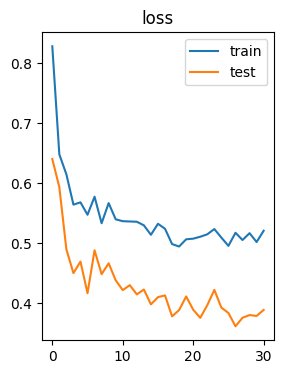

In [97]:
for epoch in range(resume, epochs):
    # training
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)            # flatten 3D data into 2D
        # calculating the loss function
        loss = nn.BCELoss()(pred, targets)      # !!!! Targets and Imputs size must match
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))
    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

In [41]:
for inputs, targets in tqdm(trainloader):
    print(model(inputs))
    print(targets)
    break

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

tensor([[0.1031],
        [0.1748],
        [0.1232],
        [0.1019],
        [0.1762],
        [0.2254],
        [0.1047],
        [0.1449],
        [0.1349],
        [0.1335],
        [0.2408],
        [0.1186],
        [0.0515],
        [0.1436],
        [0.2495],
        [0.2210],
        [0.1189],
        [0.1105],
        [0.1534],
        [0.1078]], grad_fn=<SigmoidBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [98]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor

In [99]:
eval_model(testloader, model)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 200.10it/s]
D:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


(0.8888888888888888,
 array([[1., 0.],
        [0., 0.]]),
 0.0)